<h1><center> DS420 - Homework 4: Classifications


## Goal:
Given by a home loan agency, the dataset is used to predict how reliable each applicant is of repaying a loan. Each row in the dataset represents one loan in our data sample.

Among 122 columns in the dataset, the 'TARGET' column is our label column, with '0' meaning the applicant will NOT default the repayment, and '1' being the applicant will default. 

## Setup Spark Environment for Jupyter Notebook

In [123]:
# We use the findspark library to locate the Spark package on our local machine (v. 3.0.1)



import findspark

findspark.init('/opt/spark')
from pyspark.sql import SparkSession


## Q1: Import necessary libraries, create a Spark session "hw4_xxx", and read in the given dataset into a DataFrame named "df".

In [402]:
spark = SparkSession.builder.appName('hw4_moynihan').getOrCreate()


# Load and parse the data file, converting it to a DataFrame.
from pyspark import SparkFiles

url = 'https://raw.githubusercontent.com/BlueJayADAL/DS420/master/datasets/hw4/hw4.csv'





In [403]:
spark.sparkContext.addFile(url)
fileloc = SparkFiles.get('hw4.csv')
df = spark.read.csv('file://'+fileloc, inferSchema=True, header=True)


22/04/04 23:21:10 WARN SparkContext: The path https://raw.githubusercontent.com/BlueJayADAL/DS420/master/datasets/hw4/hw4.csv has been added already. Overwriting of added paths is not supported in the current version.


#### Print the schema of the DataFrame

In [404]:

df.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- SK_ID_CURR: integer (nullable = true)
 |-- TARGET: integer (nullable = true)
 |-- NAME_CONTRACT_TYPE: string (nullable = true)
 |-- CODE_GENDER: string (nullable = true)
 |-- FLAG_OWN_CAR: string (nullable = true)
 |-- FLAG_OWN_REALTY: string (nullable = true)
 |-- CNT_CHILDREN: integer (nullable = true)
 |-- AMT_INCOME_TOTAL: double (nullable = true)
 |-- AMT_CREDIT: double (nullable = true)
 |-- AMT_ANNUITY: double (nullable = true)
 |-- AMT_GOODS_PRICE: double (nullable = true)
 |-- NAME_TYPE_SUITE: string (nullable = true)
 |-- NAME_INCOME_TYPE: string (nullable = true)
 |-- NAME_EDUCATION_TYPE: string (nullable = true)
 |-- NAME_FAMILY_STATUS: string (nullable = true)
 |-- NAME_HOUSING_TYPE: string (nullable = true)
 |-- REGION_POPULATION_RELATIVE: double (nullable = true)
 |-- DAYS_BIRTH: integer (nullable = true)
 |-- DAYS_EMPLOYED: integer (nullable = true)
 |-- DAYS_REGISTRATION: double (nullable = true)
 |-- DAYS_ID_PUBLISH: integ

#### Show the top 20 rows of columns: `TARGET`, `NAME_CONTRACT_TYPE`, `CODE_GENDER`, `FLAG_OWN_CAR`, `FLAG_OWN_REALTY`, `COMMONAREA_AVG`, and `NONLIVINGAPARTMENTS_AVG`.

In [405]:
cols_to_be_shown = ['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 
           'FLAG_OWN_REALTY', 'COMMONAREA_AVG', 'NONLIVINGAPARTMENTS_AVG']

In [406]:
df[cols_to_be_shown].show()


+------+------------------+-----------+------------+---------------+--------------+-----------------------+
|TARGET|NAME_CONTRACT_TYPE|CODE_GENDER|FLAG_OWN_CAR|FLAG_OWN_REALTY|COMMONAREA_AVG|NONLIVINGAPARTMENTS_AVG|
+------+------------------+-----------+------------+---------------+--------------+-----------------------+
|     1|        Cash loans|          M|           N|              Y|        0.0143|                    0.0|
|     0|        Cash loans|          F|           N|              N|        0.0605|                 0.0039|
|     0|   Revolving loans|          M|           Y|              Y|          null|                   null|
|     0|        Cash loans|          F|           N|              Y|          null|                   null|
|     0|        Cash loans|          M|           N|              Y|          null|                   null|
|     0|        Cash loans|          M|           N|              Y|          null|                   null|
|     0|        Cash loans| 

## Q2: Data Cleaning

#### Both `_c0` and `Sk_ID_Curr` are the ID columns which are not needed. Let's delete them from our DataFrame.

In [407]:
# Sk_ID_Curr is the id column which we dont need it in the process so we get rid of it. 
cols_to_be_dropped = ['_c0', 'SK_ID_CURR']


In [408]:
# Drop the two columns mentioned above
df = df.drop(*cols_to_be_dropped)




Check if these two columns are gone.

In [409]:
df.columns

['TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_AVG',
 'YEARS_BU

#### Rename the `Target` column to `label`

In [410]:
df = df.withColumnRenamed('Target', 'label')



#### Find the number of occurences of each label type.

In [411]:
df.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1| 8093|
|    0|91907|
+-----+-----+



As we can see, we are dealing with an imbalanced ratio of (0.92 and 0.08)

#### Use Seaborn to plot a bar chart of the label distribution.

/home/lip/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

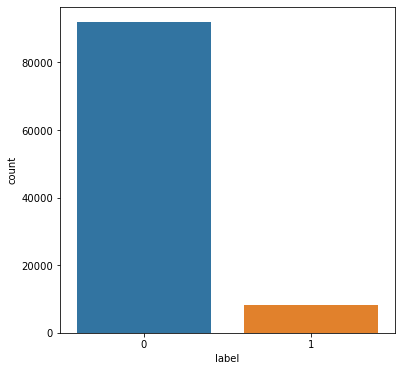

In [412]:
# let's have a look at the distribution of our target variable:
# to make it look better, we first convert our spark df to a Pandas df

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,6))

df_pd = df.toPandas()

sns.countplot(df_pd['label'])


## Q3: Find missing data.

#### First, let's see how many categorical ('string' type) and numerical ('int' or 'double' type) features we have.

Hint: the `dtypes` attributed in Spark DataFrame returns a list of two-tuples in the format of `(Column_Name, Column_Type)` as below:

In [413]:
df.dtypes

[('label', 'int'),
 ('NAME_CONTRACT_TYPE', 'string'),
 ('CODE_GENDER', 'string'),
 ('FLAG_OWN_CAR', 'string'),
 ('FLAG_OWN_REALTY', 'string'),
 ('CNT_CHILDREN', 'int'),
 ('AMT_INCOME_TOTAL', 'double'),
 ('AMT_CREDIT', 'double'),
 ('AMT_ANNUITY', 'double'),
 ('AMT_GOODS_PRICE', 'double'),
 ('NAME_TYPE_SUITE', 'string'),
 ('NAME_INCOME_TYPE', 'string'),
 ('NAME_EDUCATION_TYPE', 'string'),
 ('NAME_FAMILY_STATUS', 'string'),
 ('NAME_HOUSING_TYPE', 'string'),
 ('REGION_POPULATION_RELATIVE', 'double'),
 ('DAYS_BIRTH', 'int'),
 ('DAYS_EMPLOYED', 'int'),
 ('DAYS_REGISTRATION', 'double'),
 ('DAYS_ID_PUBLISH', 'int'),
 ('OWN_CAR_AGE', 'double'),
 ('FLAG_MOBIL', 'int'),
 ('FLAG_EMP_PHONE', 'int'),
 ('FLAG_WORK_PHONE', 'int'),
 ('FLAG_CONT_MOBILE', 'int'),
 ('FLAG_PHONE', 'int'),
 ('FLAG_EMAIL', 'int'),
 ('OCCUPATION_TYPE', 'string'),
 ('CNT_FAM_MEMBERS', 'double'),
 ('REGION_RATING_CLIENT', 'int'),
 ('REGION_RATING_CLIENT_W_CITY', 'int'),
 ('WEEKDAY_APPR_PROCESS_START', 'string'),
 ('HOUR_APPR_PR

In [414]:
cat_cols = [item[0] for item in df.dtypes if item[1] == 'string'] 
print('Categorical features:', str(len(cat_cols)))

# Add [1:] in the end will exclude the 'label' column
num_cols = [item[0] for item in df.dtypes if (item[1]=='int') or (item[1] =='double')][1:]
print('Numerical features:', str(len(num_cols)))

Categorical features: 16
Numerical features: 104


#### Define a function to find the total number of missing values and missing percentage of each column within a Spark DataFrame.
Hint: `isNull()` method ([reference](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.sql.Column.isNull.html)) given by Spark functions will be useful in boolean selection.

In [415]:
def null_count_percent(spark_df):
    """
    @name: null_count_percent
    @purpurse: given a spark dataframe, return the count and percentage of missing values for each column
    @arg: spark_df - the spark DataFrame to be checked
    @return: a list of three-tuples, in the format of: (column_name, null_count, null_percent)
    """
    results = []  # The list of three-tuples we need to return eventually
    for col_name, col_type in spark_df.dtypes:   # Loop into each column tuple
        
        # TODO: Check count of nulls in the current column column
        null_count = spark_df.filter(spark_df[col_name].isNull()).count()
        
        
        # TODO: Calculate the missing percentage
        null_percent = (null_count / spark_df.select(col_name).count())
        
        
        # TODO: Add a three-tuple to the returned list if there is any
        # missing data in the current column
        if null_count>0:
            results.append((col_name, null_count, null_percent))
        
        
        
            
    # Lastly, Return the results
    return results


In [416]:
# Now check show the results given the entire DataFrame
null_cols = null_count_percent(df)

null_cols

[('AMT_ANNUITY', 7, 7e-05),
 ('AMT_GOODS_PRICE', 81, 0.00081),
 ('NAME_TYPE_SUITE', 405, 0.00405),
 ('OWN_CAR_AGE', 66019, 0.66019),
 ('OCCUPATION_TYPE', 31224, 0.31224),
 ('CNT_FAM_MEMBERS', 1, 1e-05),
 ('EXT_SOURCE_1', 56283, 0.56283),
 ('EXT_SOURCE_2', 215, 0.00215),
 ('EXT_SOURCE_3', 19827, 0.19827),
 ('APARTMENTS_AVG', 50682, 0.50682),
 ('BASEMENTAREA_AVG', 58360, 0.5836),
 ('YEARS_BEGINEXPLUATATION_AVG', 48701, 0.48701),
 ('YEARS_BUILD_AVG', 66346, 0.66346),
 ('COMMONAREA_AVG', 69732, 0.69732),
 ('ELEVATORS_AVG', 53300, 0.533),
 ('ENTRANCES_AVG', 50281, 0.50281),
 ('FLOORSMAX_AVG', 49688, 0.49688),
 ('FLOORSMIN_AVG', 67702, 0.67702),
 ('LANDAREA_AVG', 59250, 0.5925),
 ('LIVINGAPARTMENTS_AVG', 68265, 0.68265),
 ('LIVINGAREA_AVG', 50151, 0.50151),
 ('NONLIVINGAPARTMENTS_AVG', 69275, 0.69275),
 ('NONLIVINGAREA_AVG', 55070, 0.5507),
 ('APARTMENTS_MODE', 50682, 0.50682),
 ('BASEMENTAREA_MODE', 58360, 0.5836),
 ('YEARS_BEGINEXPLUATATION_MODE', 48701, 0.48701),
 ('YEARS_BUILD_MODE', 663

#### Drop all the columns that has more than 40% of the missing data.
Hint: use a for loop with the drop() function

In [417]:
drops=[]
for i in null_cols:
    if (i[2])>0.40:
        drops.append(i[0]) 
df=df.drop(*drops)

In [418]:
# Now check again with the null_count_percent function to see if the cols are deleted.
null_cols = null_count_percent(df)

null_cols

[('AMT_ANNUITY', 7, 7e-05),
 ('AMT_GOODS_PRICE', 81, 0.00081),
 ('NAME_TYPE_SUITE', 405, 0.00405),
 ('OCCUPATION_TYPE', 31224, 0.31224),
 ('CNT_FAM_MEMBERS', 1, 1e-05),
 ('EXT_SOURCE_2', 215, 0.00215),
 ('EXT_SOURCE_3', 19827, 0.19827),
 ('OBS_30_CNT_SOCIAL_CIRCLE', 327, 0.00327),
 ('DEF_30_CNT_SOCIAL_CIRCLE', 327, 0.00327),
 ('OBS_60_CNT_SOCIAL_CIRCLE', 327, 0.00327),
 ('DEF_60_CNT_SOCIAL_CIRCLE', 327, 0.00327),
 ('DAYS_LAST_PHONE_CHANGE', 1, 1e-05),
 ('AMT_REQ_CREDIT_BUREAU_HOUR', 13437, 0.13437),
 ('AMT_REQ_CREDIT_BUREAU_DAY', 13437, 0.13437),
 ('AMT_REQ_CREDIT_BUREAU_WEEK', 13437, 0.13437),
 ('AMT_REQ_CREDIT_BUREAU_MON', 13437, 0.13437),
 ('AMT_REQ_CREDIT_BUREAU_QRT', 13437, 0.13437),
 ('AMT_REQ_CREDIT_BUREAU_YEAR', 13437, 0.13437)]

## Q4: Fix missing data

#### Split the columns that still have missing values into two groups: the categorical group and the numerical group.

In [419]:
# All the columns that have missing values
null_col_names = [x[0] for x in null_cols]
null_col_names

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

In [420]:
# Use a for loop to split the null columns into categorical and numerical groups.

null_col_names_cat = []  # List of categorical column names
null_col_names_num = []  # List of numerical column names

for cname, ctype in df.dtypes:   # Loop into each column tuple
    
    # TODO: If the cname shows up in null_col_names and ctype is 'string'
    if cname in null_col_names:
        
        if ctype == 'string':
            null_col_names_cat.append(cname)
   

    # TODO: If the cname shows up in null_col_names and ctype is either 'int' or 'double'
    if cname in null_col_names:
        if ctype == 'int':
            null_col_names_num.append(cname)
        elif ctype== 'double':
            null_col_names_num.append(cname)
      


In [421]:
null_col_names_cat

['NAME_TYPE_SUITE', 'OCCUPATION_TYPE']

In [422]:
null_col_names_num

['AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'CNT_FAM_MEMBERS',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',
 'DAYS_LAST_PHONE_CHANGE',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'AMT_REQ_CREDIT_BUREAU_QRT',
 'AMT_REQ_CREDIT_BUREAU_YEAR']

#### Now, use mode (the most occurrences) in the categorical columns to fill the missing values. Note that you don't want to take NULL values into account. 

Hint: Spark does not have a mode function, but you can consider using a combination of groupBy and orderBy.

In [423]:
# Use a duplicated DataFrame that doesn't have nulls to find the mode.

df_no_missing = df.na.drop()

In [424]:
# Iterate through the names in null_col_names_cat, and 
# fix the null values in each column with the mode

for col in null_col_names_cat:
    
    # TODO: Find the mode in the current categorical column 
    mode = df_no_missing.groupby(col).count().orderBy('count', ascending=False).first()[0]
    
    
    # TODO: Fill in the missing values with col and mode
    df = df.na.fill({col:mode})
    
    
    # print the way you did
    print(col, mode)

NAME_TYPE_SUITE Unaccompanied
OCCUPATION_TYPE Laborers


#### Now, fix the missing values in the numerical columns with the column mean.

In [425]:
# and we fill the missing numerical values with the average of each column

for col in null_col_names_num:
    # TODO: Find the mean value in the currenct numerical column
    mean_val = df.agg({col:"mean"}).collect()[0][0]
    
    
    # TODO: Fill in the missing value with col and mean_val
    df = df.na.fill({col:mean_val})
    
    
    # print the way you did
    print(col, mean_val)

AMT_ANNUITY 27085.325927814945
AMT_GOODS_PRICE 538345.1489706662
CNT_FAM_MEMBERS 2.1556715567155673
EXT_SOURCE_2 0.5142005407675158
EXT_SOURCE_3 0.5104134861849431
OBS_30_CNT_SOCIAL_CIRCLE 1.4225517442035456
DEF_30_CNT_SOCIAL_CIRCLE 0.14184382932188255
OBS_60_CNT_SOCIAL_CIRCLE 1.4057969560462713
DEF_60_CNT_SOCIAL_CIRCLE 0.09841180660760687
DAYS_LAST_PHONE_CHANGE -962.6576965769658
AMT_REQ_CREDIT_BUREAU_HOUR 0.006631008629553042
AMT_REQ_CREDIT_BUREAU_DAY 0.0073472499797835105
AMT_REQ_CREDIT_BUREAU_WEEK 0.03392904589720781
AMT_REQ_CREDIT_BUREAU_MON 0.269064149809965
AMT_REQ_CREDIT_BUREAU_QRT 0.2660259002114067
AMT_REQ_CREDIT_BUREAU_YEAR 1.892032392592678


#### Check with the null columns one more time to ensure they are all gone.

In [426]:
null_cols = null_count_percent(df)

null_cols

[]

## Q5: Fix imbalanced labels:

Imbalance labels will lead to unfair prediction, i.e., the majority class tend to be predicted more. There are many methods to mitigate this problem. One way is to under-sample the majority class or up-sample the minority class to make a more balanced results. This can be achieved with sampling with replacement.

Another way is to assign weights for each class to penalize the majority class by assigning less weight and boost the minority class by assigning bigger weight. 

We are going to create a new column in the dataset named 'weights' and assign the inverse ratio of each class as weights. In this case, the '0' class will receive 0.08 and the '1' class will receive 0.92.

We can achieve this by using withColum() function and a user defined function (udf). See example [here](https://gist.github.com/zoltanctoth/2deccd69e3d1cde1dd78).

PySpark UDF tutorial: [link](https://sparkbyexamples.com/pyspark/pyspark-udf-user-defined-function/#pyspark-udf-withcolumn)

#### Create an UDF.

In [427]:
from pyspark.sql.types import DoubleType
import pyspark.sql.functions as F

weight_udf = F.udf(lambda label: 0.08 if label ==0 else 0.92, DoubleType()
                  
                  
                  )

#### Adding the new column `weights` with udf. 

In [428]:
df = df.withColumn('weights', weight_udf(df.label))


In [429]:
df.select(['label', 'weights']).show()

+-----+-------+
|label|weights|
+-----+-------+
|    1|   0.92|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
|    0|   0.08|
+-----+-------+
only showing top 20 rows



## Q6: Feature transformation

In [430]:
# Re-run Q3 to get the most up-to-date categorical and numerical columns.

cat_cols = [item[0] for item in df.dtypes if item[1] == 'string'] 

# Note add [1:-1] at the end will exclude the 'label' and 'wegith' columns
num_cols = [item[0] for item in df.dtypes if (item[1]=='int') or (item[1] =='double')][1:-1]

print(cat_cols)
print(num_cols)

['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE']
['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_D

#### To transform all categorical features, we need to create a transformation pipeline in the sequence of: StringIndexer --> OneHotEncoder --> VectorAssembler. The cells below did not use DataFrame pipeline, however, you can use it to compare the results. [Pipeline reference link](https://spark.apache.org/docs/latest/ml-pipeline.html#example-pipeline)

Since StringIndexer() not yet support multiple columns, we want to use a for loop to apply the transformation. In addition, when applying transformation on each column, you can add a suffix such as '_index' to the resulting column names.

In [431]:
df.columns

['label',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'OBS_30_CNT_SOCIAL_CIRCLE',
 'DEF_30_CNT_SOCIAL_CIRCLE',
 'OBS_60_CNT_SOCIAL_CIRCLE',
 'DEF_60_CNT_SOCIAL_CIRCLE',


In [432]:
from pyspark.ml.feature import StringIndexer

for col in cat_cols:
    indexer = StringIndexer(inputCol=col, outputCol=col+'_index')
    
    
    df = indexer.fit(df).transform(df)
    


#### Find all the resulting columns that contain the '_index' suffix.

In [433]:
encoderInputs = []

for col in df.columns:
    # TODO
    if '_index' in col:
        encoderInputs.append(col)
        
print(encoderInputs)

['NAME_CONTRACT_TYPE_index', 'CODE_GENDER_index', 'FLAG_OWN_CAR_index', 'FLAG_OWN_REALTY_index', 'NAME_TYPE_SUITE_index', 'NAME_INCOME_TYPE_index', 'NAME_EDUCATION_TYPE_index', 'NAME_FAMILY_STATUS_index', 'NAME_HOUSING_TYPE_index', 'OCCUPATION_TYPE_index', 'WEEKDAY_APPR_PROCESS_START_index', 'ORGANIZATION_TYPE_index']


#### Apply OneHotEncoder transformation. Again, use a for loop and add '_onehot' suffix to the resulting column names.

In [434]:
from pyspark.ml.feature import OneHotEncoder

for col in encoderInputs:
    indexer = OneHotEncoder(inputCol=col, outputCol=col+'_onehot', dropLast=True)
    
    
    
    df = indexer.fit(df).transform(df)
    
    


#### Find all the resulting columns that contain the '_onehot' suffix. Add back the numerical columns. 

In [435]:
assemblerInput = []

for col in df.columns:
    # TODO
    if '_onehot' in col:
        assemblerInput.append(col)
        
        
# Addd back the numerical columns (excluding 'label' column)
assemblerInput = assemblerInput+encoderInputs+num_cols


print(assemblerInput)

['NAME_CONTRACT_TYPE_index_onehot', 'CODE_GENDER_index_onehot', 'FLAG_OWN_CAR_index_onehot', 'FLAG_OWN_REALTY_index_onehot', 'NAME_TYPE_SUITE_index_onehot', 'NAME_INCOME_TYPE_index_onehot', 'NAME_EDUCATION_TYPE_index_onehot', 'NAME_FAMILY_STATUS_index_onehot', 'NAME_HOUSING_TYPE_index_onehot', 'OCCUPATION_TYPE_index_onehot', 'WEEKDAY_APPR_PROCESS_START_index_onehot', 'ORGANIZATION_TYPE_index_onehot', 'NAME_CONTRACT_TYPE_index', 'CODE_GENDER_index', 'FLAG_OWN_CAR_index', 'FLAG_OWN_REALTY_index', 'NAME_TYPE_SUITE_index', 'NAME_INCOME_TYPE_index', 'NAME_EDUCATION_TYPE_index', 'NAME_FAMILY_STATUS_index', 'NAME_HOUSING_TYPE_index', 'OCCUPATION_TYPE_index', 'WEEKDAY_APPR_PROCESS_START_index', 'ORGANIZATION_TYPE_index', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_E

#### Lastly, apply VectorAssembler to get the final form of the DataFrame.

In [436]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=[
 'NAME_CONTRACT_TYPE_index_onehot', 'CODE_GENDER_index_onehot', 'FLAG_OWN_CAR_index_onehot', 'FLAG_OWN_REALTY_index_onehot', 'NAME_TYPE_SUITE_index_onehot', 'NAME_INCOME_TYPE_index_onehot', 'NAME_EDUCATION_TYPE_index_onehot', 'NAME_FAMILY_STATUS_index_onehot', 'NAME_HOUSING_TYPE_index_onehot', 'OCCUPATION_TYPE_index_onehot', 'WEEKDAY_APPR_PROCESS_START_index_onehot', 'ORGANIZATION_TYPE_index_onehot', 'NAME_CONTRACT_TYPE_index', 'CODE_GENDER_index', 'FLAG_OWN_CAR_index', 'FLAG_OWN_REALTY_index', 'NAME_TYPE_SUITE_index', 'NAME_INCOME_TYPE_index', 'NAME_EDUCATION_TYPE_index', 'NAME_FAMILY_STATUS_index', 'NAME_HOUSING_TYPE_index', 'OCCUPATION_TYPE_index', 'WEEKDAY_APPR_PROCESS_START_index', 'ORGANIZATION_TYPE_index', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'OBS_30_CNT_SOCIAL_CIRCLE', 'DEF_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_3', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 'FLAG_DOCUMENT_18', 'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR'],
                           outputCol = 'features')


df = assembler.transform(df)



#### Select only the 'features', 'label', and 'weights' columns

In [437]:
df = df.select(['features','label','weights'])
df.show()

+--------------------+-----+-------+
|            features|label|weights|
+--------------------+-----+-------+
|(183,[0,2,3,4,5,1...|    1|   0.92|
|(183,[0,1,3,6,14,...|    0|   0.08|
|(183,[2,4,5,11,18...|    0|   0.08|
|(183,[0,1,3,4,5,1...|    0|   0.08|
|(183,[0,2,3,4,5,1...|    0|   0.08|
|(183,[0,2,3,4,7,1...|    0|   0.08|
|(183,[0,1,4,5,12,...|    0|   0.08|
|(183,[0,2,4,5,14,...|    0|   0.08|
|(183,[0,1,3,4,8,1...|    0|   0.08|
|(183,[2,3,4,5,11,...|    0|   0.08|
|(183,[0,1,3,4,5,1...|    0|   0.08|
|(183,[0,1,3,4,8,1...|    0|   0.08|
|(183,[0,1,3,4,5,1...|    0|   0.08|
|(183,[0,2,5,11,18...|    0|   0.08|
|(183,[0,1,3,4,5,1...|    0|   0.08|
|(183,[0,2,4,6,11,...|    0|   0.08|
|(183,[0,2,3,5,11,...|    0|   0.08|
|(183,[1,3,4,5,11,...|    0|   0.08|
|(183,[1,3,4,10,11...|    0|   0.08|
|(183,[0,1,3,4,5,1...|    0|   0.08|
+--------------------+-----+-------+
only showing top 20 rows



## Q7: Training the model

#### Firstly, split the dataset into train_data and test_data with a split ratio of [0.7, 0.3]. Use seed = 101

In [438]:
# split the data into trainign and testin sets

train_data, test_data = df.randomSplit([0.7,0.3], seed = 101)



print(train_data.count())
print(test_data.count())

69748
30252


#### Train a Logistic Regression model. Ensure to specify the `weightCol` argument with the `weights` column.

In [439]:
# first we check how LogisticRegression perform 
from pyspark.ml.classification import LogisticRegression



lr = LogisticRegression(featuresCol='features',
                                    labelCol = 'label',
                                    weightCol = 'weights',
                                    predictionCol = 'prediction')


lrModel = lr.fit(train_data)


## Q8: Evaluation

#### Plot the ROC curve

In [440]:
results = lrModel.transform(test_data)

In [441]:
training_summary = lrModel.summary

ROC = training_summary.roc.toPandas()

In [442]:
ROC

,FPR,TPR
0,0.000000,0.000000
1,0.006495,0.049298
2,0.013911,0.088246
3,0.021796,0.121930
4,0.029650,0.155965
...,...,...
103,0.967930,0.996667
104,0.978719,0.997719
105,0.989430,0.999649
106,1.000000,1.000000


Text(0.5, 1.0, 'ROC Curve')

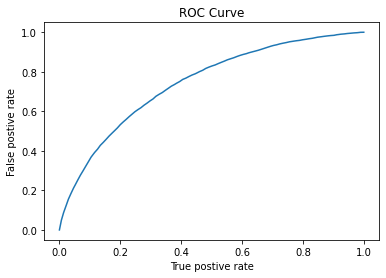

In [443]:
import matplotlib.pyplot as plt
plt.plot(ROC['FPR'], ROC['TPR'])

plt.ylabel('False postive rate')
plt.xlabel('True postive rate')
plt.title("ROC Curve")

#### Find the AUC value.

In [444]:
print ('Test Data Area Under ROC: ', training_summary.areaUnderROC)

Test Data Area Under ROC:  0.7441160508456377


#### Use sklearn's classification report to show the classification performance

In [445]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [446]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')

In [447]:
evaluator.evaluate(results)


0.7368658980547482

In [448]:
y_true = results.select(['label']).collect()
y_pred = results.select(['prediction']).collect()

In [449]:
from sklearn.metrics import classification_report, confusion_matrix


In [450]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.68      0.80     27859
           1       0.15      0.67      0.25      2393

    accuracy                           0.68     30252
   macro avg       0.56      0.68      0.52     30252
weighted avg       0.90      0.68      0.75     30252



## Q9: Open-ended question

#### Try to improve the model's F1 score by the following methods:
+ Feature importance study --> Feature selection and elimination.
+ Feature dimensionality reduction with PCA or LDA. 
+ Use and fine-tune other classifiction models.

Note: Your final grade of this question depends on how many **reasonable** methods have been tried. The final F1 score is the least important. 

# decision tree, random forest, and gradient boosted trees

In [451]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.ml.classification import GBTClassifier

In [452]:
# Use mostly defaults to make this comparison "fair"

dtc = DecisionTreeClassifier(labelCol='label',maxBins=58)

rfc = RandomForestClassifier(labelCol='label',maxBins=58)

gbt = GBTClassifier(labelCol='label',maxBins=58)



In [453]:
# Train the models (there are three models, so it might take some time)
dtc_model = dtc.fit(train_data)

rfc_model = rfc.fit(train_data)

gbt_model = gbt.fit(train_data)

In [454]:
dtc_predictions = dtc_model.transform(test_data)

rfc_predictions = rfc_model.transform(test_data)

gbt_predictions = gbt_model.transform(test_data)

In [455]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [456]:
acc_evaluator = MulticlassClassificationEvaluator(labelCol='label',
                                                 metricName='accuracy')



In [457]:
dtc_acc = acc_evaluator.evaluate(dtc_predictions)

rfc_acc = acc_evaluator.evaluate(rfc_predictions)

gbt_acc = acc_evaluator.evaluate(gbt_predictions)


In [458]:
print("Model accuracy:")
print('Decision tree: {0:2.2f}%'.format(dtc_acc*100))
print('Random forest: {0:2.2f}%'.format(rfc_acc*100))
print('GBT: {0:2.2f}%'.format(gbt_acc*100))

Model accuracy:
Decision tree: 92.07%
Random forest: 92.09%
GBT: 92.07%


In [459]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
evaluator.evaluate(dtc_predictions)
y_true = dtc_predictions.select(['label']).collect()
y_pred = dtc_predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27859
           1       0.00      0.00      0.00      2393

    accuracy                           0.92     30252
   macro avg       0.46      0.50      0.48     30252
weighted avg       0.85      0.92      0.88     30252



This f1 score is very high, the decision tree splits at nodes to classify

In [460]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
evaluator.evaluate(rfc_predictions)
y_true = rfc_predictions.select(['label']).collect()
y_pred = rfc_predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27859
           1       0.00      0.00      0.00      2393

    accuracy                           0.92     30252
   macro avg       0.46      0.50      0.48     30252
weighted avg       0.85      0.92      0.88     30252



/home/lip/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lip/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/lip/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


This f1 score is very high, random forest randomly picks features in tree splits

In [461]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
evaluator.evaluate(gbt_predictions)
y_true = gbt_predictions.select(['label']).collect()
y_pred = gbt_predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.92      1.00      0.96     27859
           1       0.38      0.00      0.01      2393

    accuracy                           0.92     30252
   macro avg       0.65      0.50      0.48     30252
weighted avg       0.88      0.92      0.88     30252



This is a very high f1 score. This boosted other features in unbalanced data.

# GBT Classifier

In [462]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [463]:


# Train a GBT model.
gbt = GBTClassifier(featuresCol='features',
                                    labelCol = 'label',
                                    weightCol = 'weights',
                                    predictionCol = 'prediction', maxIter=10, maxBins=58)


# Make predictions.
predictions = model.transform(test_data)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

gbtModel = model.stages[2]
print(gbtModel)  # summary only

+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         0.0|(183,[0,1,3,4,5,1...|
|       0.0|         0.0|(183,[0,1,3,4,5,1...|
|       0.0|         0.0|(183,[0,1,3,4,5,1...|
|       0.0|         0.0|(183,[0,1,3,4,5,1...|
|       0.0|         0.0|(183,[0,1,3,4,5,1...|
+----------+------------+--------------------+
only showing top 5 rows

Accuracy = 0.66789
GBTClassificationModel: uid = GBTClassifier_71dca872a9f2, numTrees=10, numClasses=2, numFeatures=183


In [464]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')

In [465]:
evaluator.evaluate(predictions)


0.7236158197209044

In [466]:
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()

In [467]:
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.67      0.79     27859
           1       0.15      0.66      0.24      2393

    accuracy                           0.67     30252
   macro avg       0.55      0.67      0.51     30252
weighted avg       0.89      0.67      0.74     30252



This model is important because it boosts less inportant features in an unbalanced output like we had. We did give specify the weights earlier in a question but not in the boosted model. The f1 score is a little lower but not by much.

# OneVsRest

In [468]:
from pyspark.ml.classification import LogisticRegression, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [469]:
lr = LogisticRegression(maxIter=10, tol=1E-6, fitIntercept=True)

# instantiate the One Vs Rest Classifier.
ovr = OneVsRest(classifier=lr)

# train the multiclass model.
ovrModel = ovr.fit(train_data)

# score the model on test data.
predictions = ovrModel.transform(test_data)

# obtain evaluator.
evaluator = MulticlassClassificationEvaluator(metricName="accuracy")

# compute the classification error on test data.
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g" % (accuracy))

22/04/04 23:22:51 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed
22/04/04 23:22:55 ERROR LBFGS: Failure! Resetting history: breeze.optimize.FirstOrderException: Line search failed


Accuracy = 0.920865


The accuracy score is high here. The classifier takes instances of Classifier and creates a binary classification problem for each of the k classes. The classifier for class i is trained to predict whether the label is i or not, distinguishing class i from all other classes.

# Factorization machines classifier

In [474]:
predictions = model.transform(test_data)

# Select example rows to display.
predictions.select("prediction", "indexedLabel", "features").show(5)

# Select (prediction, true label) and compute test accuracy
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test set accuracy = %g" % accuracy)



+----------+------------+--------------------+
|prediction|indexedLabel|            features|
+----------+------------+--------------------+
|       1.0|         0.0|(183,[0,1,3,4,5,1...|
|       0.0|         0.0|(183,[0,1,3,4,5,1...|
|       0.0|         0.0|(183,[0,1,3,4,5,1...|
|       0.0|         0.0|(183,[0,1,3,4,5,1...|
|       0.0|         0.0|(183,[0,1,3,4,5,1...|
+----------+------------+--------------------+
only showing top 5 rows

Test set accuracy = 0.66789


In [475]:
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderROC')
evaluator.evaluate(predictions)
y_true = predictions.select(['label']).collect()
y_pred = predictions.select(['prediction']).collect()
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       0.96      0.67      0.79     27859
           1       0.15      0.66      0.24      2393

    accuracy                           0.67     30252
   macro avg       0.55      0.67      0.51     30252
weighted avg       0.89      0.67      0.74     30252



This output has a similar F1 score to the other models. This is a held-out test set. I scaled features to be between 0 and 1 to prevent the exploding gradient problem.

# Great Job!